<a href="https://colab.research.google.com/github/mersalas/MLBS-2025_workshop/blob/main/Lab_4_MD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hello there!**

This is a Jupyter notebook for running Molecular Dynamics (MD) simulations using OpenMM engine and AMBER force field. This notebook is a supplementary material of the paper "***Making it rain: Cloud-based molecular simulations for everyone***" ([link here](https://doi.org/10.1021/acs.jcim.1c00998)) and we encourage you to read it before using this pipeline.

The main goal of this notebook is to demonstrate how to harness the power of cloud-computing to run microsecond-long MD simulations in a cheap and yet feasible fashion.

---

 **This notebook is NOT a standard protocol for MD simulations!** It is just simple MD pipeline illustrating each step of a simulation protocol.

---
**Bugs**
- If you encounter any bugs, please report the issue to https://github.com/pablo-arantes/making-it-rain/issues

**Acknowledgments**
- We would like to thank the OpenMM team for developing an excellent and open source engine.

- A Making-it-rain by **Pablo R. Arantes** ([@pablitoarantes](https://twitter.com/pablitoarantes)), **Marcelo D. Polêto** ([@mdpoleto](https://twitter.com/mdpoleto)), **Conrado Pedebos** ([@ConradoPedebos](https://twitter.com/ConradoPedebos)) and **Rodrigo Ligabue-Braun** ([@ligabue_braun](https://twitter.com/ligabue_braun)).


- Also, credit to [David Koes](https://github.com/dkoes) for his awesome [py3Dmol](https://3dmol.csb.pitt.edu/) plugin.

- For related notebooks see: [Making-it-rain](https://github.com/pablo-arantes/making-it-rain)

# **Introduction**

In general, MD simulations rely on 1) a set of atomic coordinates of all atoms on a simulation box and 2) a set of force field parameters that describes the interaction energies between atoms.

In terms of AMBER inputs, we wil need:
*  A PDB ID or a .pdb file containing a set of atomic coordinates of your molecule.

In this notebook, we will simulate PDB 1AKI, a hen egg-white lysozyme. To build our simulation box, we will use LEaP program (https://ambermd.org/tutorials/pengfei/index.php). The LEaP program is a portal between many chemical structure file types (.pdb and .mol2, primarily), and the Amber model parameter file types such as .lib, .prepi, parm.dat, and .frcmod. Each of the parameter files contains pieces of information needed for constructing a simulation, whether for energy minimization or molecular dynamics. LEaP functions within a larger workflow described in Section 1.1 of the [Amber Manual](https://ambermd.org/doc12/Amber20.pdf);.
## ---







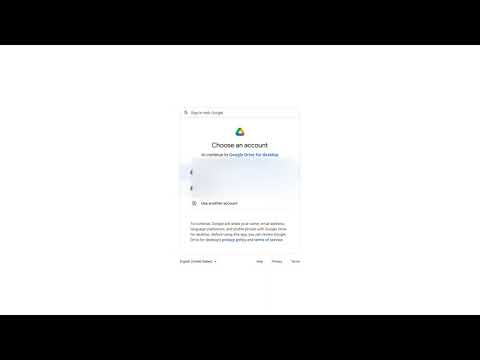

In [2]:
#@title ### **Video Demonstration**
#@markdown Check the timelapse movie to understand how the pipeline works
from IPython.display import YouTubeVideo
YouTubeVideo('pVa0mQS6xeo', width=800, height=500)

---
---
# **Setting the environment for MD calculation**

Firstly, we need to install all necessary libraries and packages for our simulation. The main packages we will be installing are:

1.    Anaconda (https://docs.conda.io/en/latest/miniconda.html)
2.    OpenMM (https://openmm.org/)
3.    PyTraj (https://amber-md.github.io/pytraj/latest/index.html)
4.    py3Dmol (https://pypi.org/project/py3Dmol/)
5.    Numpy (https://numpy.org/)
6.    Matplotlib (https://matplotlib.org/)
7.    AmberTools (https://ambermd.org/AmberTools.php)

In [3]:
#@title **Install Conda Colab**
#@markdown It will restart the kernel (session), don't worry.
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:12
🔁 Restarting kernel...


In [1]:
#@title **Install dependencies**
#@markdown It will take a few minutes, please, drink a coffee and wait. ;-)
# install dependencies
import subprocess
import sys
subprocess.run("rm -rf /usr/local/conda-meta/pinned", shell=True)
subprocess.run("mamba install -c conda-forge ambertools -y", shell=True)
import pytraj as pt
subprocess.run("pip -q install py3Dmol", shell=True)
subprocess.run("pip install git+https://github.com/pablo-arantes/biopandas", shell=True)
subprocess.run("mamba install openmm", shell=True)
subprocess.run("pip install --upgrade MDAnalysis", shell=True)

#load dependencies
import sys
from biopandas.pdb import PandasPdb
import openmm as mm
from openmm import *
from openmm.app import *
from openmm.unit import *
import os
import urllib.request
import numpy as np
import MDAnalysis as mda
import py3Dmol
import pytraj as pt
import platform
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata
import seaborn as sb
from statistics import mean, stdev
from pytraj import matrix
from matplotlib import colors
from IPython.display import set_matplotlib_formats
import subprocess

## Using Google Drive to store simulation data

Google Colab does not allow users to keep data on their computing nodes. However, we can use Google Drive to read, write, and store our simulations files. Therefore, we suggest to you to:

1.   Create a folder in your own Google Drive and copy the necessary input files there.
2.   Copy the path of your created directory. We will use it below.

In [2]:
#@title ### **Import Google Drive**
#@markdown Click in the "Run" buttom to make your Google Drive accessible.
from google.colab import drive

drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [3]:
#@title **Check if you correctly allocated GPU nodes**

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat Apr 19 01:50:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

---
---
# **Loading the necessary input files**

At this point, we should have all libraries and dependencies installed and all necessary input files already at your Google Drive folder.

**Important**: We have 2 cells below, if we want to use PDB ID as an input structure to run the MD simuatons, we should fill and run only the first cell. In the other hand, if we want to use our own structure, we should upload the PDB file to the correct pathway and run only the second cell. Make sure the PDB file points to the correct pathway. If necessary, correct the pathway and re-upload the files.



Below, you should provide the names of all input files and the pathway of your Google Drive folder containing them. Please, don't use spaces in the files and folders names, i.e., protein_input.pdb, amber_test.pdb and so on.


In [ ]:
#@title **If you want to use the PDB ID, please, provide the necessary input below:**
%%capture
Query_PDB_ID = '1AKI' #@param {type:"string"}
query_PDB = Query_PDB_ID
Google_Drive_Path = '/content/drive/MyDrive/' #@param {type:"string"}
workDir = Google_Drive_Path

remove_waters = "yes" #@param ["yes", "no" ]
if remove_waters == "yes":
  no_waters = "nowat"
else:
  no_waters = ''

starting = os.path.join(workDir, "starting.pdb")
starting2 = os.path.join(workDir, "starting2.pdb")
starting3 = os.path.join(workDir, "starting3.pdb")
starting_end = os.path.join(workDir, "starting_end.pdb")
tleap = os.path.join(workDir, "tleap.in")
prepareforleap = os.path.join(workDir, "prepareforleap.in")
top_nw = os.path.join(workDir, "SYS_nw.prmtop")
crd_nw = os.path.join(workDir, "SYS_nw.crd")
pdb_nw = os.path.join(workDir, "SYS_nw.pdb")
top = os.path.join(workDir, "SYS.prmtop")
crd = os.path.join(workDir, "SYS.crd")
pdb = os.path.join(workDir, "SYS.pdb")

pdbfn = query_PDB + ".pdb"
url = 'https://files.rcsb.org/download/' + pdbfn
outfnm = os.path.join(workDir, pdbfn)
urllib.request.urlretrieve(url, outfnm)
ppdb = PandasPdb().read_pdb(outfnm)
ppdb.df['ATOM'] = ppdb.df['ATOM']
# ppdb.df['HETATM'] = ppdb.df['HETATM'][ppdb.df['HETATM']['residue_name'] == 'HOH']
ppdb.df['ATOM'] = ppdb.df['ATOM'][ppdb.df['ATOM']['atom_name'] != 'OXT']
ppdb.df['ATOM']= ppdb.df['ATOM'][ppdb.df['ATOM']['element_symbol'] != 'H']
ppdb.to_pdb(path=starting, records=['ATOM', 'HETATM'], gz=False, append_newline=True)

# from Bio.PDB import is_aa
# from Bio.PDB import PDBParser, PDBIO, Select


# class ProtSelect(Select):
#     def accept_residue(self, residue):
#         print(f"{residue} -> {is_aa(residue)}")
#         return is_aa(residue, standard=True)


# from Bio import PDB

# pdb_ini = PDBParser().get_structure("pdb", starting)
# io = PDBIO()
# io.set_structure(pdb_ini)
# io.save(starting2, ProtSelect());

def remove_lines(filename):
    with open(filename, 'r') as file:
        ter_count = 0
        for line in file:
            if line.startswith('TER'):
                ter_count += 1
                if ter_count >= 1:
                    yield line
                    for i in range(3):
                        line = next(file, None)
                        if line is not None and line.startswith('ATOM') and line.split()[2] in ['P', 'OP1', 'OP2']:
                            continue
                        else:
                            yield line
                else:
                    yield line
            else:
                yield line


f = open(prepareforleap, "w")
f.write("""parm """ + str(starting) + "\n"
"""loadcrd """ + str(starting) + """ name edited""" + "\n"
"""prepareforleap crdset edited name from-prepareforleap \ """ + "\n"
"""pdbout """ + str(starting2) + " " + str(no_waters) + """ noh""" + "\n"
"""go """)
f.close()

prepareforleap_command = "cpptraj -i " + str(prepareforleap)
original_stdout = sys.stdout # Save a reference to the original standard output
with open('prepareforleap.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(prepareforleap_command)
    sys.stdout = original_stdout # Reset the standard output to its original value

subprocess.run(["chmod 700 prepareforleap.sh"], shell=True)
subprocess.run(["./prepareforleap.sh"], shell=True,)


pdb4amber_cmd = "pdb4amber -i " + str(starting2) + " -o " + str(starting3) + " -a -y"
original_stdout = sys.stdout # Save a reference to the original standard output

with open('pdb4amber.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(pdb4amber_cmd)
    sys.stdout = original_stdout # Reset the standard output to its original value

subprocess.run(["chmod 700 pdb4amber.sh"], shell=True)
subprocess.run(["./pdb4amber.sh"], shell=True,)

with open(starting_end, 'w') as out_file:
    for line in remove_lines(starting3):
        if line is not None:
          out_file.write(line)
        else:
          pass

#@markdown **ATTENTION**: If you ran the present cell, you can ignore the next step.


#@markdown ---

# Generate a peptide using [AlphaFold3 webserver](https://alphafoldserver.com/) & convert [CIF into PDB](https://project-gemmi.github.io/wasm/convert/cif2pdb.html)

In [4]:
#@title If you want to use your own **SYSTEM**, please, provide the necessary input file below:
#@markdown **Remember**, this pipeline works only for protein, nucleic acids and glycans systems. If you submit a different structure (small drug), you will probably have an error in the topology generation.
%%capture
PDB_file_name = 'ano5.pdb' #@param {type:"string"}
file_name = PDB_file_name
Google_Drive_Path = '/content/' #@param {type:"string"}
workDir = Google_Drive_Path

remove_waters = "yes" #@param ["yes", "no" ]
if remove_waters == "yes":
  no_waters = "nowat"
else:
  no_waters = ''

initial_pdb = os.path.join(workDir, str(file_name))
starting = os.path.join(workDir, "starting.pdb")
starting2 = os.path.join(workDir, "starting2.pdb")
starting3 = os.path.join(workDir, "starting3.pdb")
prepareforleap = os.path.join(workDir, "prepareforleap.in")
starting_end = os.path.join(workDir, "starting_end.pdb")
tleap = os.path.join(workDir, "tleap.in")
top_nw = os.path.join(workDir, "SYS_nw.prmtop")
crd_nw = os.path.join(workDir, "SYS_nw.crd")
pdb_nw = os.path.join(workDir, "SYS_nw.pdb")
top = os.path.join(workDir, "SYS.prmtop")
crd = os.path.join(workDir, "SYS.crd")
pdb = os.path.join(workDir, "SYS.pdb")

ppdb = PandasPdb().read_pdb(initial_pdb)
ppdb.df['ATOM'] = ppdb.df['ATOM']
# ppdb.df['HETATM'] = ppdb.df['HETATM'][ppdb.df['HETATM']['residue_name'] == 'HOH']
ppdb.df['ATOM'] = ppdb.df['ATOM'][ppdb.df['ATOM']['atom_name'] != 'OXT']
ppdb.df['ATOM']= ppdb.df['ATOM'][ppdb.df['ATOM']['element_symbol'] != 'H']
ppdb.to_pdb(path=starting, records=['ATOM', 'HETATM'], gz=False, append_newline=True)

# from Bio.PDB import is_aa
# from Bio.PDB import PDBParser, PDBIO, Select


# class ProtSelect(Select):
#     def accept_residue(self, residue):
#         print(f"{residue} -> {is_aa(residue)}")
#         return is_aa(residue, standard=True)


# from Bio import PDB

# pdb_ini = PDBParser().get_structure("pdb", starting)
# io = PDBIO()
# io.set_structure(pdb_ini)
# io.save(starting2, ProtSelect());



# pdb4amber_cmd = "pdb4amber -i " + str(starting2) + " -o " + str(starting_end) + " -p"

# original_stdout = sys.stdout # Save a reference to the original standard output

# with open('pdb4amber.sh', 'w') as f:
#     sys.stdout = f # Change the standard output to the file we created.
#     print(pdb4amber_cmd)
#     sys.stdout = original_stdout # Reset the standard output to its original value

# !chmod 700 pdb4amber.sh 2>&1 1>/dev/null
# !bash pdb4amber.sh 2> /dev/null

def remove_lines(filename):
    with open(filename, 'r') as file:
        ter_count = 0
        for line in file:
            if line.startswith('TER'):
                ter_count += 1
                if ter_count >= 1:
                    yield line
                    for i in range(3):
                        line = next(file, None)
                        if line is not None and line.startswith('ATOM') and line.split()[2] in ['P', 'OP1', 'OP2']:
                            continue
                        else:
                            yield line
                else:
                    yield line
            else:
                yield line


f = open(prepareforleap, "w")
f.write("""parm """ + str(starting) + "\n"
"""loadcrd """ + str(starting) + """ name edited""" + "\n"
"""prepareforleap crdset edited name from-prepareforleap \ """ + "\n"
"""pdbout """ + str(starting2) + " " + str(no_waters) + """ noh""" + "\n"
"""go """)
f.close()

prepareforleap_command = "cpptraj -i " + str(prepareforleap)
original_stdout = sys.stdout # Save a reference to the original standard output
with open('prepareforleap.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(prepareforleap_command)
    sys.stdout = original_stdout # Reset the standard output to its original value

subprocess.run(["chmod 700 prepareforleap.sh"], shell=True)
subprocess.run(["./prepareforleap.sh"], shell=True,)


pdb4amber_cmd = "pdb4amber -i " + str(starting2) + " -o " + str(starting3) + " -a"
original_stdout = sys.stdout # Save a reference to the original standard output

with open('pdb4amber.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(pdb4amber_cmd)
    sys.stdout = original_stdout # Reset the standard output to its original value

subprocess.run(["chmod 700 pdb4amber.sh"], shell=True)
subprocess.run(["./pdb4amber.sh"], shell=True,)

with open(starting_end, 'w') as out_file:
    for line in remove_lines(starting3):
        if line is not None:
          out_file.write(line)
        else:
          pass

#@markdown **ATTENTION**: If you didn't run the previous cell, you should run this step.

#@markdown ---

In [5]:
#@title **Parameters to generate the Amber topology:**

Force_field = "ff19SB" #@param ["ff19SB", "ff14SB"]
if Force_field == "ff19SB":
  ff = "leaprc.protein.ff19SB"
else:
  ff = "leaprc.protein.ff14SB"

Water_type = "OPC" #@param ["TIP3P", "OPC"]
if Water_type == "TIP3P":
  water = "leaprc.water.tip3p"
  water_box = "TIP3PBOX"
else:
  water = "leaprc.water.opc"
  water_box = "OPCBOX"

#@markdown Size Box (Angstrons):

Size_box = 10 #@param {type:"slider", min:10, max:20, step:1}
size_box = Size_box

#@markdown **ATTENTION**: Give the concentration in Molar units, AMBER tleap will neutralize your system automatically:

Ions = "NaCl" #@param ["NaCl", "KCl" ]

Concentration = "0" #@param {type:"string"}

#@markdown ---

f = open(tleap, "w")
f.write("""source """ + str(ff) + "\n"
"""source leaprc.DNA.OL15
source leaprc.RNA.OL3
source leaprc.GLYCAM_06j-1
source leaprc.gaff2
source """  + str(water) + "\n"
"""SYS = loadpdb """  + str(starting_end) + "\n"
"""alignaxes SYS
savepdb SYS """ + str(pdb_nw) + "\n"
"""saveamberparm SYS """ + str(top_nw) + " " + str(crd_nw) + "\n"
"""solvatebox SYS """ + str(water_box) + " " + str(size_box) +  """ 0.7
saveamberparm SYS """ + str(top) + " " + str(crd) + "\n"
"""savepdb SYS """ + str(pdb) + "\n"
"""quit""")
f.close()

tleap_command = "tleap -f " + str(tleap)

original_stdout = sys.stdout # Save a reference to the original standard output

with open('run_tleap.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(tleap_command)
    sys.stdout = original_stdout # Reset the standard output to its original value

SYS = os.path.join(workDir, "SYS*")
rm_sys = "rm " + SYS

original_stdout = sys.stdout # Save a reference to the original standard output

with open('rm_sys.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(rm_sys)
    sys.stdout = original_stdout # Reset the standard output to its original value

subprocess.run(["chmod 700 rm_sys.sh"], shell=True)
subprocess.run(["./rm_sys.sh"], shell=True,)
subprocess.run(["chmod 700 run_tleap.sh"], shell=True)
subprocess.run(["./run_tleap.sh"], shell=True,)


subprocess.run(['grep "Volume:" leap.log > temp.txt'], shell=True)
with open("temp.txt", 'r') as f:
  for line in f:
        vol = float(line.split()[1])

vol_lit  = vol * pow(10, -27)
atom_lit = 9.03 * pow(10, 22)
conc = float(Concentration)
num_ion = int(vol_lit * (conc/0.15) * atom_lit)

if Ions == "NaCl":
  pos_neut = "Na+ 0"
  pos_num = "Na+ " + str(num_ion)
  Cl_num = num_ion
else:
  pos_neut = "K+ 0"
  pos_num = "K+ " + str(num_ion)
  Cl_num = num_ion

f = open(tleap, "w")
f.write("""source """ + str(ff) + "\n"
"""source leaprc.DNA.OL15
source leaprc.RNA.OL3
source leaprc.GLYCAM_06j-1
source leaprc.gaff2
source """  + str(water) + "\n"
"""SYS = loadpdb """  + str(starting_end) + "\n"
"""alignaxes SYS
check SYS
charge SYS
addions SYS """ + str(pos_neut) + "\n"
"""addions SYS Cl- 0
check SYS
charge SYS
savepdb SYS """ + str(pdb_nw) + "\n"
"""saveamberparm SYS """ + str(top_nw) + " " + str(crd_nw) + "\n"
"""solvatebox SYS """ + str(water_box) + " " + str(size_box) +  """ 0.7 """ + "\n"
"""addIonsRand SYS """ + str(pos_num) + """ Cl- """ + str(Cl_num) + "\n"
"""saveamberparm SYS """ + str(top) + " " + str(crd) + "\n"
"""savepdb SYS """ + str(pdb) + "\n"
"""quit""")
f.close()

subprocess.run(["chmod 700 run_tleap.sh"], shell=True)
subprocess.run(["./run_tleap.sh"], shell=True,)

pdb_amber = os.path.exists(pdb)
top_amber = os.path.exists(top)
crd_amber = os.path.exists(crd)

subprocess.run(["rm *.sh temp.txt"], shell=True,)

if pdb_amber == True and top_amber == True and crd_amber == True:
  print("Successfully generated topology! :-)")
else:
  print("ERROR: Check your input file! ")

Successfully generated topology! :-)


## Let's take a look on our simulation box:

In [6]:
#@title **Show 3D structure**
import warnings
warnings.filterwarnings('ignore')
import py3Dmol

color = "gray" #@param ["gray", "rainbow"]
show_sidechains = True #@param {type:"boolean"}
show_mainchains = True #@param {type:"boolean"}
show_box = True #@param {type:"boolean"}
box_opacity = 0.6 #@param {type:"slider", min:0, max:1, step:0.1}


def show_pdb(show_sidechains=False, show_mainchains=False, show_box = False, color="rainbow"):
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb,'r').read(),'pdb')

  if color == "gray":
    view.setStyle({'cartoon':{}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})

  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  if show_box:
    view.addSurface(py3Dmol.SAS, {'opacity': box_opacity, 'color':'white'})

  view.zoomTo()
  return view


show_pdb(show_sidechains, show_mainchains, show_box, color).show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

---
---
# **Equilibrating the simulation box**

Proper MD equilibration protocol is designed to equilibrate both temperature and pressure throughout the simulation box while preserving the protein experimental conformation. In addition, we also allow the solvent to accomodate around the protein, creating proper solvation layers.

Below, we will set up the MD equilibration parameters, such as temperature, pressure and the desired simulation time. We will define the force constant used to restraint protein heavy-atoms in place and the frequency at which we want to save atomic coordinates in a trajectory file (.dcd).

After you are done, you can run the next 2 cells to equilibrate your system.

In [7]:
#@title ### **Parameters for MD Equilibration protocol:**

# remove whitespaces
Jobname = 'ano5_equil' #@param {type:"string"}

Minimization_steps = "1000" #@param ["1000", "5000", "10000", "20000", "50000", "100000"]

#@markdown Simulation time (in nanoseconds) and integration time (in femtoseconds):
Time = "0.2" #@param {type:"string"}
stride_time_eq = Time
Integration_timestep = "2" #@param ["0.5", "1", "2", "3", "4"]
dt_eq = Integration_timestep

#@markdown Temperature (in Kelvin) and Pressure (in bar)
Temperature = 298 #@param {type:"string"}
temperature_eq = Temperature
Pressure = 1 #@param {type:"string"}
pressure_eq = Pressure

#@markdown Position restraints force constant (in kJ/mol):
Force_constant = 500 #@param {type:"slider", min:0, max:2000, step:100}

#@markdown Frequency to write the trajectory file (in picoseconds):

Write_the_trajectory = "10" #@param ["10", "100", "200", "500", "1000"]
write_the_trajectory_eq = Write_the_trajectory
#@markdown Frequency to write the log file (in picoseconds):

Write_the_log = "10" #@param ["10", "100", "200", "500", "1000"]
write_the_log_eq = Write_the_log


#@markdown ---


In [8]:
#@title **Runs an Equilibration MD simulation (NPT ensemble)**
#@markdown Now, let's equilibrate our system!

###########################################
import openmm as mm
from openmm import *
from openmm.app import *
from openmm.unit import *
import pytraj as pt

from sys import stdout, exit, stderr
import os, math, fnmatch

#############################################
# Defining MD simulation parameters

jobname = os.path.join(workDir, Jobname)
coordinatefile = os.path.join(workDir, "SYS.crd")
pdbfile = os.path.join(workDir, "SYS.pdb")
topologyfile = os.path.join(workDir, "SYS.prmtop")

time_ps = float(Time)*1000
simulation_time = float(time_ps)*picosecond		# in ps
dt = int(dt_eq)*femtosecond
temperature = float(temperature_eq)*kelvin
savcrd_freq = int(write_the_trajectory_eq)*picosecond
print_freq  = int(write_the_log_eq)*picosecond

pressure	= float(pressure_eq)*bar

restraint_fc = int(Force_constant) # kJ/mol

nsteps  = int(simulation_time.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
nprint  = int(print_freq.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
nsavcrd = int(savcrd_freq.value_in_unit(picosecond)/dt.value_in_unit(picosecond))

#############################################
# Defining functions to use below:
def backup_old_log(pattern, string):
	result = []
	for root, dirs, files in os.walk("./"):
		for name in files:
			if fnmatch.fnmatch(name, pattern):

				try:
					number = int(name[-2])
					avail = isinstance(number, int)
					#print(name,avail)
					if avail == True:
						result.append(number)
				except:
					pass

	if len(result) > 0:
		maxnumber = max(result)
	else:
		maxnumber = 0

	backup_file = "\#" + string + "." + str(maxnumber + 1) + "#"
	os.system("mv " + string + " " + backup_file)
	return backup_file

def restraints(system, crd, fc, restraint_array):

	boxlx = system.getDefaultPeriodicBoxVectors()[0][0].value_in_unit(nanometers)
	boxly = system.getDefaultPeriodicBoxVectors()[1][1].value_in_unit(nanometers)
	boxlz = system.getDefaultPeriodicBoxVectors()[2][2].value_in_unit(nanometers)

	if fc > 0:
		# positional restraints for all heavy-atoms
		posresPROT = CustomExternalForce('k*periodicdistance(x, y, z, x0, y0, z0)^2;')
		posresPROT.addPerParticleParameter('k')
		posresPROT.addPerParticleParameter('x0')
		posresPROT.addPerParticleParameter('y0')
		posresPROT.addPerParticleParameter('z0')

		for atom1 in restraint_array:
			atom1 = int(atom1)

			xpos  = crd.positions[atom1].value_in_unit(nanometers)[0]
			ypos  = crd.positions[atom1].value_in_unit(nanometers)[1]
			zpos  = crd.positions[atom1].value_in_unit(nanometers)[2]

			posresPROT.addParticle(atom1, [fc, xpos, ypos, zpos])

		system.addForce(posresPROT)

	return system
##############################################

#############################################
print("\n> Simulation details:\n")
print("\tJob name = " + jobname)
print("\tCoordinate file = " + str(coordinatefile))
print("\tPDB file = " + str(pdbfile))
print("\tTopology file = " + str(topologyfile))

print("\n\tSimulation_time = " + str(simulation_time))
print("\tIntegration timestep = " + str(dt))
print("\tTotal number of steps = " +  str(nsteps))

print("\n\tSave coordinates each " + str(savcrd_freq))
print("\tPrint in log file each " + str(print_freq))

print("\n\tTemperature = " + str(temperature))
print("\tPressure = " + str(pressure))
#############################################

print("\n> Setting the system:\n")

print("\t- Reading topology and structure file...")
prmtop = AmberPrmtopFile(topologyfile)
inpcrd = AmberInpcrdFile(coordinatefile)

print("\t- Creating system and setting parameters...")
nonbondedMethod = PME
nonbondedCutoff = 1.0*nanometers
ewaldErrorTolerance = 0.0005
constraints = HBonds
rigidWater = True
constraintTolerance = 0.000001
friction = 1.0
system = prmtop.createSystem(nonbondedMethod=nonbondedMethod, nonbondedCutoff=nonbondedCutoff,
                           constraints=constraints, rigidWater=rigidWater, ewaldErrorTolerance=ewaldErrorTolerance)

print("\t- Applying restraints. Force Constant = " + str(Force_constant) + "kJ/mol")
pt_system = pt.iterload(coordinatefile, topologyfile)
pt_topology = pt_system.top
restraint_array = pt.select_atoms('!(:H*) & !(:WAT) & !(:Na+) & !(:Cl-) & !(:Mg+) & !(:K+)', pt_topology)

system = restraints(system, inpcrd, restraint_fc, restraint_array)

print("\t- Setting barostat...")
system.addForce(MonteCarloBarostat(pressure, temperature))

print("\t- Setting integrator...")
integrator = LangevinIntegrator(temperature, friction, dt)
integrator.setConstraintTolerance(constraintTolerance)
simulation = Simulation(prmtop.topology, system, integrator)
simulation.context.setPositions(inpcrd.positions)
if inpcrd.boxVectors is not None:
    simulation.context.setPeriodicBoxVectors(*inpcrd.boxVectors)

print("\t- Energy minimization: " + str(Minimization_steps) + " steps")
simulation.minimizeEnergy(tolerance=10*kilojoule/mole/nanometer, maxIterations=int(Minimization_steps))

print("\t-> Potential Energy = " + str(simulation.context.getState(getEnergy=True).getPotentialEnergy()))

print("\t- Setting initial velocities...")
simulation.context.setVelocitiesToTemperature(temperature)

#############################################
# Running Equilibration on NPT ensemble

dcd_file = jobname + ".dcd"
log_file = jobname + ".log"
rst_file = jobname + ".rst"
prv_rst_file = jobname + ".rst"
pdb_file = jobname + ".pdb"

# Creating a trajectory file and reporters
dcd = DCDReporter(dcd_file, nsavcrd)
firstdcdstep = (nsteps) + nsavcrd
dcd._dcd = DCDFile(dcd._out, simulation.topology, simulation.integrator.getStepSize(), firstdcdstep, nsavcrd) # charmm doesn't like first step to be 0

simulation.reporters.append(dcd)
simulation.reporters.append(StateDataReporter(stdout, nprint, step=True, speed=True, progress=True, totalSteps=nsteps, remainingTime=True, separator='\t\t'))
simulation.reporters.append(StateDataReporter(log_file, nprint, step=True, kineticEnergy=True, potentialEnergy=True, totalEnergy=True, temperature=True, volume=True, speed=True))

print("\n> Simulating " + str(nsteps) + " steps...")
simulation.step(nsteps)

simulation.reporters.clear() # remove all reporters so the next iteration don't trigger them.


##################################
# Writing last frame information of stride
print("\n> Writing state file (" + str(rst_file) + ")...")
state = simulation.context.getState( getPositions=True, getVelocities=True )
with open(rst_file, 'w') as f:
	f.write(XmlSerializer.serialize(state))

last_frame = int(nsteps/nsavcrd)
print("> Writing coordinate file (" + str(pdb_file) + ", frame = " + str(last_frame) + ")...")
positions = simulation.context.getState(getPositions=True).getPositions()
PDBFile.writeFile(simulation.topology, positions, open(pdb_file, 'w'))

print("\n> Finished!\n")


> Simulation details:

	Job name = /content/ano5_equil
	Coordinate file = /content/SYS.crd
	PDB file = /content/SYS.pdb
	Topology file = /content/SYS.prmtop

	Simulation_time = 200.0 ps
	Integration timestep = 2 fs
	Total number of steps = 100000

	Save coordinates each 10 ps
	Print in log file each 10 ps

	Temperature = 298.0 K
	Pressure = 1.0 bar

> Setting the system:

	- Reading topology and structure file...
	- Creating system and setting parameters...
	- Applying restraints. Force Constant = 500kJ/mol
	- Setting barostat...
	- Setting integrator...
	- Energy minimization: 1000 steps
	-> Potential Energy = -73197.56807299715 kJ/mol
	- Setting initial velocities...

> Simulating 100000 steps...
#"Progress (%)"		"Step"		"Speed (ns/day)"		"Time Remaining"
5.0%		5000		0		--
10.0%		10000		526		0:29
15.0%		15000		526		0:27
20.0%		20000		522		0:26
25.0%		25000		535		0:24
30.0%		30000		543		0:22
35.0%		35000		549		0:20
40.0%		40000		554		0:18
45.0%		45000		557		0:17
50.0%		50000		559		0:

---
---
# **Running a Production MD simulation**

Finally, we will proceed with the Production simulation itself using the equilibrated system coordinates as input structure.

Note that we will use here a *.rst state file* , which contains atomic velocities and positions from the last frame of the equilibration simulation, guaranteeing that our production simulation begins from a thermodynamically equilibrated system.

Another important information here is the **Number_of_strides** and the **Stride_Time**. In this notebook, we simulate a defined number of *strides*, so the **simulation time = Number_of_strides*Stride_Time**. For example, we can simulate 100ns by setting *Number_of_strides=10* and *Stride_Time=10 ns*.

**Important: at the end of the Production simulation, we concatenate all strides to create a complete trajectory file which can be visualized and analyzed**

The idea behind this approach is to make use of the intermitent 12h/24h period that Google Colab allows us to use its GPUs.

In [9]:
#@markdown ### **Provide input file names below:**

Equilibrated_PDB = 'ano5_equil.pdb' #@param {type:"string"}
State_file = 'ano5_equil.rst' #@param {type:"string"}

#@markdown ---
#@markdown ### **Parameters for MD Production protocol:**


# remove whitespaces
Jobname = 'ano5_prod' #@param {type:"string"}

#@markdown Simulation time (in nanoseconds), number of strides (integers) and integration timestep (in femtoseconds):
Stride_Time = "2" #@param {type:"string"}
stride_time_prod = Stride_Time
Number_of_strides = "1" #@param {type:"string"}
nstride = Number_of_strides
Integration_timestep = "2" #@param ["0.5", "1", "2", "3", "4"]
dt_prod = Integration_timestep

#@markdown Temperature (in Kelvin) and Pressure (in bar)
Temperature = 298 #@param {type:"string"}
temperature_prod = Temperature
Pressure = 1 #@param {type:"string"}
pressure_prod = Pressure

#@markdown Frequency to write the trajectory file (in picoseconds):
Write_the_trajectory = "10" #@param ["10", "100", "200", "500", "1000"]
write_the_trajectory_prod = Write_the_trajectory

#@markdown Frequency to write the log file (in picoseconds):
Write_the_log = "10" #@param ["10", "100", "200", "500", "1000"]
write_the_log_prod = Write_the_log

#@markdown ---

In [10]:
#@title **Runs a Production MD simulation (NPT ensemble) after equilibration**
#
###########################################
import openmm as mm
from openmm import *
from openmm.app import *
from openmm.unit import *

from sys import stdout, exit, stderr
import os, math, fnmatch

#############################################
# Defining MD simulation parameters

jobname = os.path.join(workDir, str(Jobname))
coordinatefile = os.path.join(workDir, "SYS.crd")
pdbfile = os.path.join(workDir, Equilibrated_PDB)
topologyfile = os.path.join(workDir, "SYS.prmtop")
equil_rst_file = os.path.join(workDir, State_file)


stride_time_ps = float(stride_time_prod)*1000
stride_time = float(stride_time_ps)*picosecond
nstride = int(Number_of_strides)
dt = int(dt_prod)*femtosecond
temperature = float(temperature_prod)*kelvin
savcrd_freq = int(write_the_trajectory_prod)*picosecond
print_freq  = int(write_the_log_prod)*picosecond

pressure	= float(pressure_prod)*bar

simulation_time = stride_time*nstride
nsteps  = int(stride_time.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
nprint  = int(print_freq.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
nsavcrd = int(savcrd_freq.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
firststride = 1 # must be integer
#############################################
# Defining functions to use below:
def backup_old_log(pattern, string):
	result = []
	for root, dirs, files in os.walk("./"):
		for name in files:
			if fnmatch.fnmatch(name, pattern):

				try:
					number = int(name[-2])
					avail = isinstance(number, int)
					#print(name,avail)
					if avail == True:
						result.append(number)
				except:
					pass

	if len(result) > 0:
		maxnumber = max(result)
	else:
		maxnumber = 0

	backup_file = "\#" + string + "." + str(maxnumber + 1) + "#"
	os.system("mv " + string + " " + backup_file)
	return backup_file
##############################################

#############################################
print("\n> Simulation details:\n")
print("\tJob name = " + jobname)
print("\tCoordinate file = " + str(coordinatefile))
print("\tPDB file = " + str(pdbfile))
print("\tTopology file = " + str(topologyfile))

print("\n\tSimulation_time = " + str(stride_time*nstride))
print("\tIntegration timestep = " + str(dt))
print("\tTotal number of steps = " +  str(nsteps*nstride))
print("\tNumber of strides = " + str(nstride) + " (" + str(stride_time) + " in each stride)")

print("\n\tSave coordinates each " + str(savcrd_freq))
print("\tSave checkpoint each " + str(savcrd_freq))
print("\tPrint in log file each " + str(print_freq))

print("\n\tTemperature = " + str(temperature))
print("\tPressure = " + str(pressure))
#############################################

print("\n> Setting the system:\n")

print("\t- Reading topology and structure file...")
prmtop = AmberPrmtopFile(topologyfile)
inpcrd = AmberInpcrdFile(coordinatefile)


print("\t- Creating system and setting parameters...")
nonbondedMethod = PME
nonbondedCutoff = 1.0*nanometers
ewaldErrorTolerance = 0.0005
constraints = HBonds
rigidWater = True
constraintTolerance = 0.000001
friction = 1.0
system = prmtop.createSystem(nonbondedMethod=nonbondedMethod, nonbondedCutoff=nonbondedCutoff,
                           constraints=constraints, rigidWater=rigidWater, ewaldErrorTolerance=ewaldErrorTolerance)

print("\t- Setting barostat...")
system.addForce(MonteCarloBarostat(pressure, temperature))

print("\t- Setting integrator...")
integrator = LangevinIntegrator(temperature, friction, dt)
integrator.setConstraintTolerance(constraintTolerance)
simulation = Simulation(prmtop.topology, system, integrator)
simulation.context.setPositions(inpcrd.positions)
if inpcrd.boxVectors is not None:
	simulation.context.setPeriodicBoxVectors(*inpcrd.boxVectors)

#############################################
# Opening a loop of extension NSTRIDE to simulate the entire STRIDE_TIME*NSTRIDE
for n in range(1, nstride + 1):

	print("\n\n>>> Simulating Stride #" + str(n) + " <<<")

	dcd_file = jobname + "_" + str(n) + ".dcd"
	log_file = jobname + "_" + str(n) + ".log"
	rst_file = jobname + "_" + str(n) + ".rst"
	prv_rst_file = jobname + "_" + str(n-1) + ".rst"
	pdb_file = jobname + "_" + str(n) + ".pdb"

	if os.path.exists(rst_file):
		print("> Stride #" + str(n) + " finished (" + rst_file + " present). Moving to next stride... <")
		continue

	if n == 1:
		print("\n> Loading previous state from equilibration > " + equil_rst_file + " <")
		with open(equil_rst_file, 'r') as f:
			simulation.context.setState(XmlSerializer.deserialize(f.read()))
			currstep = int((n-1)*nsteps)
			currtime = currstep*dt.in_units_of(picosecond)
			simulation.currentStep = currstep
			simulation.context.setTime(currtime)
			print("> Current time: " + str(currtime) + " (Step = " + str(currstep) + ")")

	else:
		print("> Loading previous state from > " + prv_rst_file + " <")
		with open(prv_rst_file, 'r') as f:
			simulation.context.setState(XmlSerializer.deserialize(f.read()))
			currstep = int((n-1)*nsteps)
			currtime = currstep*dt.in_units_of(picosecond)
			simulation.currentStep = currstep
			simulation.context.setTime(currtime)
			print("> Current time: " + str(currtime) + " (Step = " + str(currstep) + ")")


	dcd = DCDReporter(dcd_file, nsavcrd)
	firstdcdstep = (currstep) + nsavcrd
	dcd._dcd = DCDFile(dcd._out, simulation.topology, simulation.integrator.getStepSize(), firstdcdstep, nsavcrd) # first step should not be 0

	simulation.reporters.append(dcd)
	simulation.reporters.append(StateDataReporter(stdout, nprint, step=True, speed=True, progress=True, totalSteps=(nsteps*nstride), remainingTime=True, separator='\t\t'))
	simulation.reporters.append(StateDataReporter(log_file, nprint, step=True, kineticEnergy=True, potentialEnergy=True, totalEnergy=True, temperature=True, volume=True, speed=True))

	print("\n> Simulating " + str(nsteps) + " steps... (Stride #" + str(n) + ")")
	simulation.step(nsteps)

	simulation.reporters.clear() # remove all reporters so the next iteration don't trigger them.


	##################################
	# Writing last frame information of stride
	print("\n> Writing state file (" + str(rst_file) + ")...")
	state = simulation.context.getState( getPositions=True, getVelocities=True )
	with open(rst_file, 'w') as f:
		f.write(XmlSerializer.serialize(state))

	last_frame = int(nsteps/nsavcrd)
	print("> Writing coordinate file (" + str(pdb_file) + ", frame = " + str(last_frame) + ")...")
	positions = simulation.context.getState(getPositions=True).getPositions()
	PDBFile.writeFile(simulation.topology, positions, open(pdb_file, 'w'))

print("\n> Finished!\n")


> Simulation details:

	Job name = /content/ano5_prod
	Coordinate file = /content/SYS.crd
	PDB file = /content/ano5_equil.pdb
	Topology file = /content/SYS.prmtop

	Simulation_time = 2000.0 ps
	Integration timestep = 2 fs
	Total number of steps = 1000000
	Number of strides = 1 (2000.0 ps in each stride)

	Save coordinates each 10 ps
	Save checkpoint each 10 ps
	Print in log file each 10 ps

	Temperature = 298.0 K
	Pressure = 1.0 bar

> Setting the system:

	- Reading topology and structure file...
	- Creating system and setting parameters...
	- Setting barostat...
	- Setting integrator...


>>> Simulating Stride #1 <<<

> Loading previous state from equilibration > /content/ano5_equil.rst <
> Current time: 0.0 ps (Step = 0)

> Simulating 1000000 steps... (Stride #1)
#"Progress (%)"		"Step"		"Speed (ns/day)"		"Time Remaining"
0.5%		5000		0		--
1.0%		10000		562		5:04
1.5%		15000		569		4:59
2.0%		20000		564		5:00
2.5%		25000		560		5:00
3.0%		30000		562		4:58
3.5%		35000		562		4:56
4.0%		

In [11]:
#@title **Concatenate and align the trajectory**
#@markdown **Important**: The **Google Drive Path**, **Jobname**, **Number of strides**, **stride time** and **trajectory saved frequency** should be the same you have been used to run your simulation in the previous steps.

import MDAnalysis as mda
from MDAnalysis.analysis import align, rms

Google_Drive_Path = '/content/' #@param {type:"string"}
workDir = Google_Drive_Path
Equilibrated_PDB = 'ano5_equil.pdb' #@param {type:"string"}
Jobname = "ano5_prod" #@param {type: "string"}
Skip = "1" #@param ["1", "2", "5", "10", "20", "50"]
stride_traj = Skip
Output_format = "dcd" #@param ["dcd", "pdb", "trr", "xtc"]
first_stride = "1" #@param {type:"string"}
Number_of_strides = "1" #@param {type:"string"}
nstride = int(Number_of_strides)
stride_time = "2" #@param {type:"string"}
trajectory_saved_frequency = "10" #@param ["10", "100", "200", "500", "1000"]
traj_save_freq = trajectory_saved_frequency
Remove_waters = "yes" #@param ["yes", "no"]
# stride_id_as_ref_for_alignment = "1" #@param {type: "string"}
output_prefix = first_stride+"-"+str(int(first_stride)+nstride-1)

stride_time_ps = float(stride_time)*1000
simulation_time_analysis = stride_time_ps*nstride
simulation_ns = float(stride_time)*int(Number_of_strides)
number_frames = int(simulation_time_analysis)/int(traj_save_freq)
number_frames_analysis = number_frames/int(stride_traj)


# traj_end = os.path.join(workDir, str(Jobname) + "_all.dcd")
nw_dcd = os.path.join(workDir, str(Jobname) + output_prefix + "_nw." + str(Output_format))
nw_pdb = os.path.join(workDir, str(Jobname) +  "_nw.pdb")
whole_pdb = os.path.join(workDir, str(Jobname) +  "_whole.pdb")
whole_dcd = os.path.join(workDir, str(Jobname) + output_prefix + "_whole." + str(Output_format))
template =  os.path.join(workDir, str(Jobname) + '_%s.dcd')
pdb = os.path.join(workDir, Equilibrated_PDB)

flist = [template % str(i) for i in range(int(first_stride), int(first_stride) + nstride)]
ref = [template % int(1)]

u1 = mda.Universe(pdb, flist)
u2 = mda.Universe(pdb, ref)

u2.trajectory[0] # set u2 to first frame

# print(rms.rmsd(u1.select_atoms('name CA').positions, u2.select_atoms('name CA').positions, superposition=False))

align.AlignTraj(u1, u2, select='name CA', in_memory=True).run()

nw = u1.select_atoms("not (resname HOH)")
if Remove_waters == "yes":
  with mda.Writer(nw_dcd, nw.n_atoms) as W:
    for ts in u1.trajectory[::int(Skip)]:
        W.write(nw, )
  not_waters = u2.select_atoms("not (resname HOH)")
  not_waters.write(nw_pdb)
  traj_dcd_check = os.path.exists(nw_dcd)
  traj = nw_dcd
  pdb_ref = nw_pdb
else:
  with mda.Writer(whole_dcd, u1.select_atoms("all").n_atoms) as W:
    for ts in u1.trajectory[::int(Skip)]:
        W.write(u1.select_atoms("all"))
  whole = u2.select_atoms("all")
  whole.write(whole_pdb)
  traj_dcd_check = os.path.exists(whole_dcd)
  traj = whole_dcd
  pdb_ref = whole_pdb

traj_load = pt.load(traj, pdb_ref)
print(traj_load)

if traj_dcd_check == True:
  print("Trajectory concatenated successfully! :-)")
else:
  print("ERROR: Check your inputs! ")

pytraj.Trajectory, 200 frames: 
Size: 0.000420 (GB)
<Topology: 94 atoms, 5 residues, 1 mols, PBC with box type = orthorhombic>
           
Trajectory concatenated successfully! :-)


In [12]:
#@title **Load, view and check the trajectory**
#@markdown This will take a few minutes. Another coffee would be great. :-)

import warnings
warnings.filterwarnings('ignore')

#py3dmol functions
class Atom(dict):
  def __init__(self, line):
    self["type"] = line[0:6].strip()
    self["idx"] = line[6:11].strip()
    self["name"] = line[12:16].strip()
    self["resname"] = line[17:20].strip()
    self["resid"] = int(int(line[22:26]))
    self["x"] = float(line[30:38])
    self["y"] = float(line[38:46])
    self["z"] = float(line[46:54])
    self["sym"] = line[76:78].strip()

  def __str__(self):
    line = list(" " * 80)
    line[0:6] = self["type"].ljust(6)
    line[6:11] = self["idx"].ljust(5)
    line[12:16] = self["name"].ljust(4)
    line[17:20] = self["resname"].ljust(3)
    line[22:26] = str(self["resid"]).ljust(4)
    line[30:38] = str(self["x"]).rjust(8)
    line[38:46] = str(self["y"]).rjust(8)
    line[46:54] = str(self["z"]).rjust(8)
    line[76:78] = self["sym"].rjust(2)
    return "".join(line) + "\n"

class Molecule(list):
  def __init__(self, file):
    for line in file:
      if "ATOM" in line or "HETATM" in line:
        self.append(Atom(line))

    def __str__(self):
      outstr = ""
      for at in self:
        outstr += str(at)
      return outstr

if number_frames_analysis > 10:
  stride_animation = number_frames_analysis/10
else:
  stride_animation = 1

u = mda.Universe(pdb_ref, traj)

# Write out frames for animation
protein = u.select_atoms('not (resname WAT)')
i = 0
for ts in u.trajectory[0:len(u.trajectory):int(stride_animation)]:
    if i > -1:
        with mda.Writer('' + str(i) + '.pdb', protein.n_atoms) as W:
            W.write(protein)
    i = i + 1
# Load frames as molecules
molecules = []
for i in range(int(len(u.trajectory)/int(stride_animation))):
    with open('' + str(i) + '.pdb') as ifile:
        molecules.append(Molecule(ifile))

models = ""
for i in range(len(molecules)):
  models += "MODEL " + str(i) + "\n"
  for j,mol in enumerate(molecules[i]):
    models += str(mol)
  models += "ENDMDL\n"
#view.addModelsAsFrames(models)

# Animation
view = py3Dmol.view(width=800, height=600)
view.addModelsAsFrames(models)
for i, at in enumerate(molecules[0]):
    default = {"cartoon": {'color': 'spectrum'}}
    view.setStyle({'model': -1, 'serial': i+1}, at.get("pymol", default))

view.zoomTo()
view.animate({'loop': "forward"})
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

---
---
# **Analysis**

Although visualizing your trajectory can be quite useful, sometimes you also want more quantitative data.

Analyses of MD trajectories vary a lot and we do not intend to cover it all here. However, one can make use of MDanalysis or PyTraj to easily analyze simulations.

Below, you can find a few examples of code snippets that can help you to shed some light on your simulation behavior.

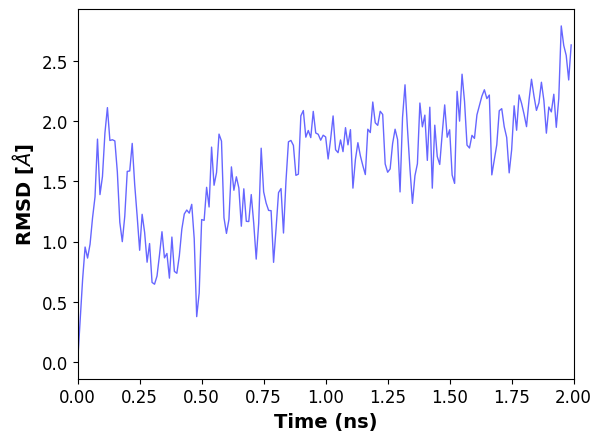

In [13]:
#@title **Compute RMSD of protein's CA atoms**
#@markdown **Provide output file names below:**
Output_name = 'rmsd_ca' #@param {type:"string"}


rmsd = pt.rmsd(traj_load, ref = 0, mask = "@CA")

time = len(rmsd)*int(Write_the_trajectory)/1000
time_array = np.arange(0,time,int(Write_the_trajectory)/1000)*int(stride_traj)

# Plotting:
ax = plt.plot(time_array, rmsd, alpha=0.6, color = 'blue', linewidth = 1.0)
plt.xlim(0, simulation_ns)
#plt.ylim(2, 6)

plt.xlabel("Time (ns)", fontsize = 14, fontweight = 'bold')
plt.ylabel("RMSD [$\AA$]", fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

raw_data=pd.DataFrame(rmsd)
raw_data.to_csv(os.path.join(workDir, Output_name + ".csv"))

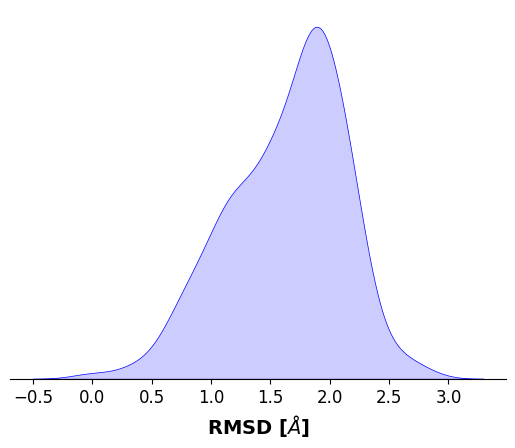

In [14]:
#@title **Plot RMSD as a ditribution**

#@markdown **Provide output file names below:**
Output_name = 'rmsd_dist' #@param {type:"string"}

ax = sb.kdeplot(rmsd, color="blue", shade=True, alpha=0.2, linewidth=0.5)
plt.xlabel('RMSD [$\AA$]', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks([])
plt.ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)

plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

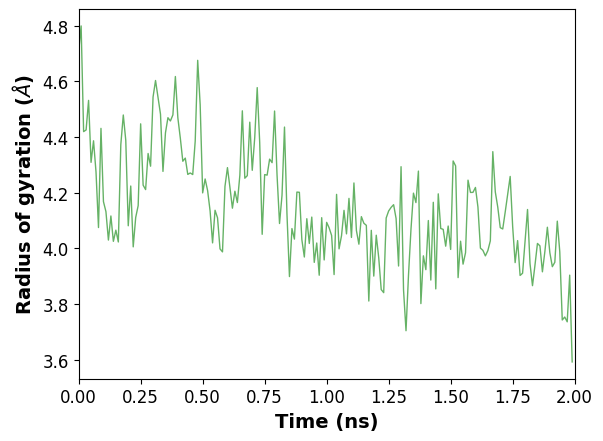

In [15]:
#@title **Compute radius of gyration of protein's CA atoms**

#@markdown **Provide output file names below:**
Output_name = 'radius_gyration' #@param {type:"string"}

radgyr = pt.radgyr(traj_load, mask = "@CA")
time = len(rmsd)*int(Write_the_trajectory)/1000
time_array = np.arange(0,time,int(Write_the_trajectory)/1000)*int(stride_traj)

# Plotting:
plt.plot(time_array, radgyr, alpha=0.6, color = 'green', linewidth = 1.0)
plt.xlim(0, simulation_ns)
#plt.ylim(2, 6)

plt.xlabel("Time (ns)", fontsize = 14, fontweight = 'bold')
plt.ylabel("Radius of gyration ($\AA$)", fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

raw_data=pd.DataFrame(radgyr)
raw_data.to_csv(os.path.join(workDir, Output_name + ".csv"))

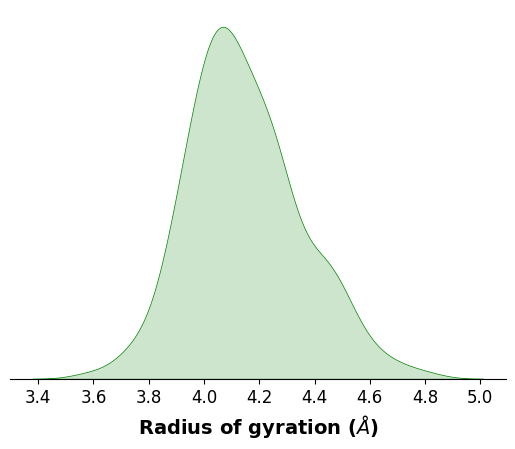

In [16]:
#@title **Plot radius of gyration as a ditribution**

#@markdown **Provide output file names below:**
Output_name = 'radius_gyration_dist' #@param {type:"string"}

ax = sb.kdeplot(radgyr, color="green", shade=True, alpha=0.2, linewidth=0.5)
plt.xlabel('Radius of gyration ($\AA$)', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks([])
plt.ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)

plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

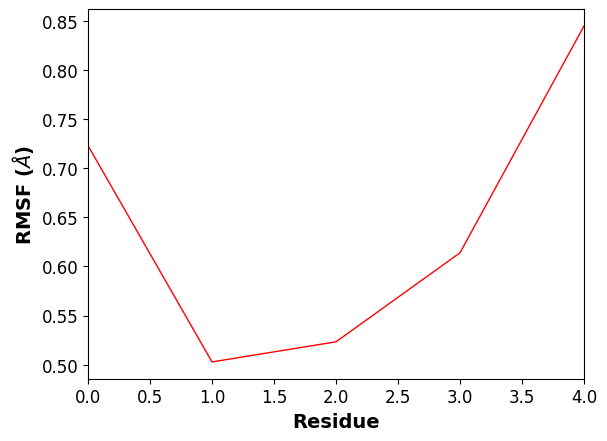

In [17]:
#@title **Compute RMSF of protein's CA atoms**

#@markdown **Provide output file names below:**
Output_name = 'rmsf_ca' #@param {type:"string"}


rmsf = pt.rmsf(traj_load, "@CA")
bfactor = pt.bfactors(traj_load, byres=True)

# Plotting:
plt.plot(rmsf[:,1], alpha=1.0, color = 'red', linewidth = 1.0)

plt.xlabel("Residue", fontsize = 14, fontweight = 'bold')
plt.ylabel("RMSF ($\AA$)", fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.xlim(0, len(rmsf[:-1]))

#plt.xticks(np.arange(min(rmsf[:1]), max(rmsf[:1])))
plt.yticks(fontsize = 12)
plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

raw_data=pd.DataFrame(rmsf)
raw_data.to_csv(os.path.join(workDir, Output_name + ".csv"))

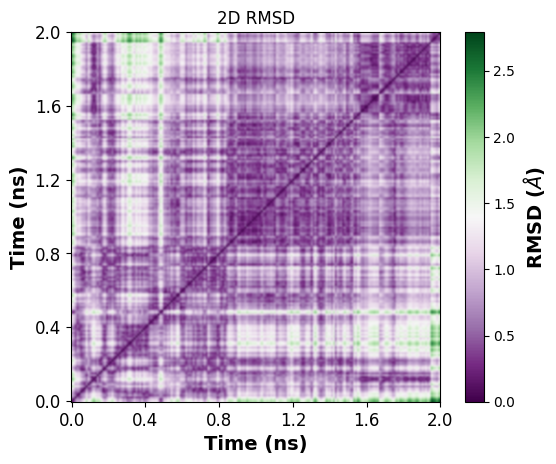

In [18]:
#@title **2D RMSD**

#@markdown **Provide output file names below:**
Output_name = '2D_rmsd' #@param {type:"string"}

last_frame = len(time_array)

stride_ticks_f = (last_frame)/5
ticks_frame = np.arange(0,(len(time_array) + float(stride_ticks_f)), float(stride_ticks_f))
a = ticks_frame.astype(float)
stride_ticks_t = (simulation_ns)/5
tick_time = np.arange(0,(float(simulation_ns) + float(stride_ticks_t)), float(stride_ticks_t))
b = tick_time.astype(float)

mat1 = pt.pairwise_rmsd(traj_load, mask="@CA", frame_indices=range(int(number_frames_analysis)))


ax = plt.imshow(mat1, cmap = 'PRGn', origin='lower', interpolation = 'bicubic')
plt.title('2D RMSD')
plt.xlabel('Time (ns)', fontsize = 14, fontweight = 'bold')
plt.ylabel('Time (ns)', fontsize = 14, fontweight = 'bold')
# plt.xticks(fontsize = 12)
# plt.yticks(fontsize = 12)
plt.xticks(a, b.round(decimals=3), fontsize = 12)
plt.yticks(a, b.round(decimals=3), fontsize = 12)
# plt.xlim(0, a[-1])
# plt.ylim(0, a[-1])

cbar1 = plt.colorbar()
cbar1.set_label("RMSD ($\AA$)", fontsize = 14, fontweight = 'bold')


plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

raw_data=pd.DataFrame(mat1)
raw_data.to_csv(os.path.join(workDir, Output_name + ".csv"))

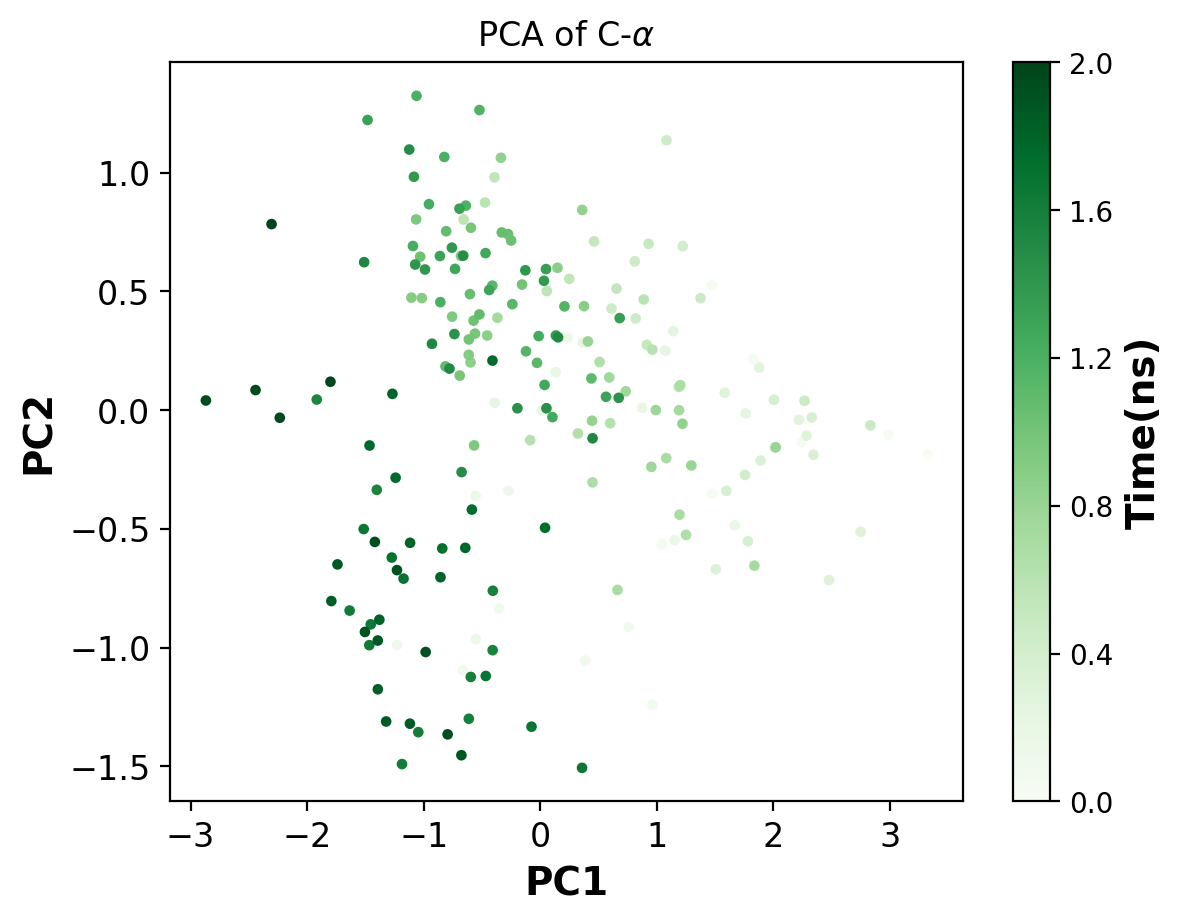

In [19]:
#@title **Calculate eigvenctors of Principle Component Analysis (PCA)**
data = pt.pca(traj_load, fit=True, ref=0, mask='@CA', n_vecs=2)
#print('projection values of each frame to first mode = {} \n'.format(data[0][0]))
#print('projection values of each frame to second mode = {} \n'.format(data[0][1]))
#print('eigvenvalues of first two modes', data[1][0])
#print("")
#print('eigvenvectors of first two modes: \n', data[1][1])

last_frame = len(time_array)

stride_ticks_f = (last_frame)/5
ticks_frame = np.arange(0,(len(time_array) + float(stride_ticks_f)), float(stride_ticks_f))
a = ticks_frame.astype(float)
a2 = a.tolist()
stride_ticks_t = (simulation_ns)/5
tick_time = np.arange(0,(float(simulation_ns) + float(stride_ticks_t)), float(stride_ticks_t))
b = tick_time.astype(float)

#@markdown **Provide output file names below:**
Output_name = 'PCA' #@param {type:"string"}

Output_PC1 = 'PC1' #@param {type:"string"}
Output_PC2 = 'PC2' #@param {type:"string"}

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # high resolution
projection_data = data[0]
plt.title(r'PCA of C-$\alpha$')
PC1 = data[0][0]
PC2 = data[0][1]

a = plt.scatter(PC1,PC2, c=range(int(number_frames_analysis)), cmap='Greens', marker='o',s=8, alpha=1)
plt.clim(0, last_frame)

plt.xlabel('PC1', fontsize = 14, fontweight = 'bold')
plt.ylabel('PC2', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
# N = len(number_frames)
# x2 = np.arange(N)

cbar1 = plt.colorbar(a, orientation="vertical")
cbar1.set_label('Time(ns)', fontsize = 14, fontweight = 'bold')
cbar1.set_ticks(a2)
cbar1.set_ticklabels(b.round(decimals=3))

plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

pc1=pd.DataFrame(PC1)
pc1.to_csv(os.path.join(workDir, Output_PC1 + ".csv"))
pc2=pd.DataFrame(PC2)
pc2.to_csv(os.path.join(workDir, Output_PC2 + ".csv"))

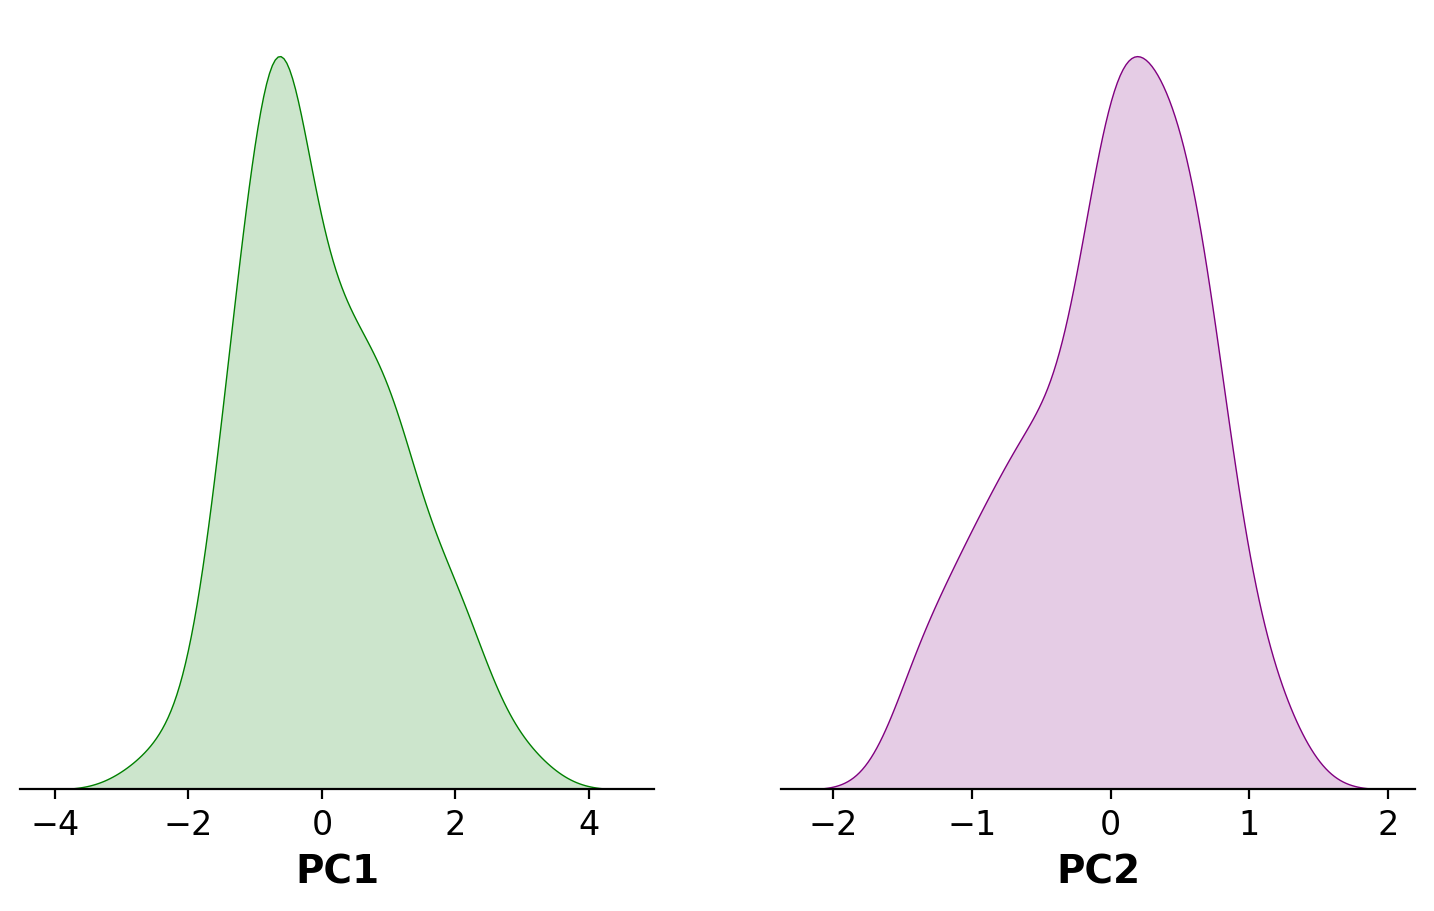

In [20]:
#@title **Plot Principal Component 1 (PC1) and Principal Component 2 (PC2) as a ditribution**
Output_name = 'PCA_dist' #@param {type:"string"}


fig = plt.figure(figsize=(9,5))

plt.subplot(1, 2, 1)
ax = sb.kdeplot(PC1, color="green", shade=True, alpha=0.2, linewidth=0.5)
plt.xlabel('PC1', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks([])
plt.ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)
plt.subplot(1, 2, 2)
ax2 = sb.kdeplot(PC2, color="purple", shade=True, alpha=0.2, linewidth=0.5)
plt.xlabel('PC2', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks([])
plt.ylabel('')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
ax2.spines['left'].set_visible(False)


plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

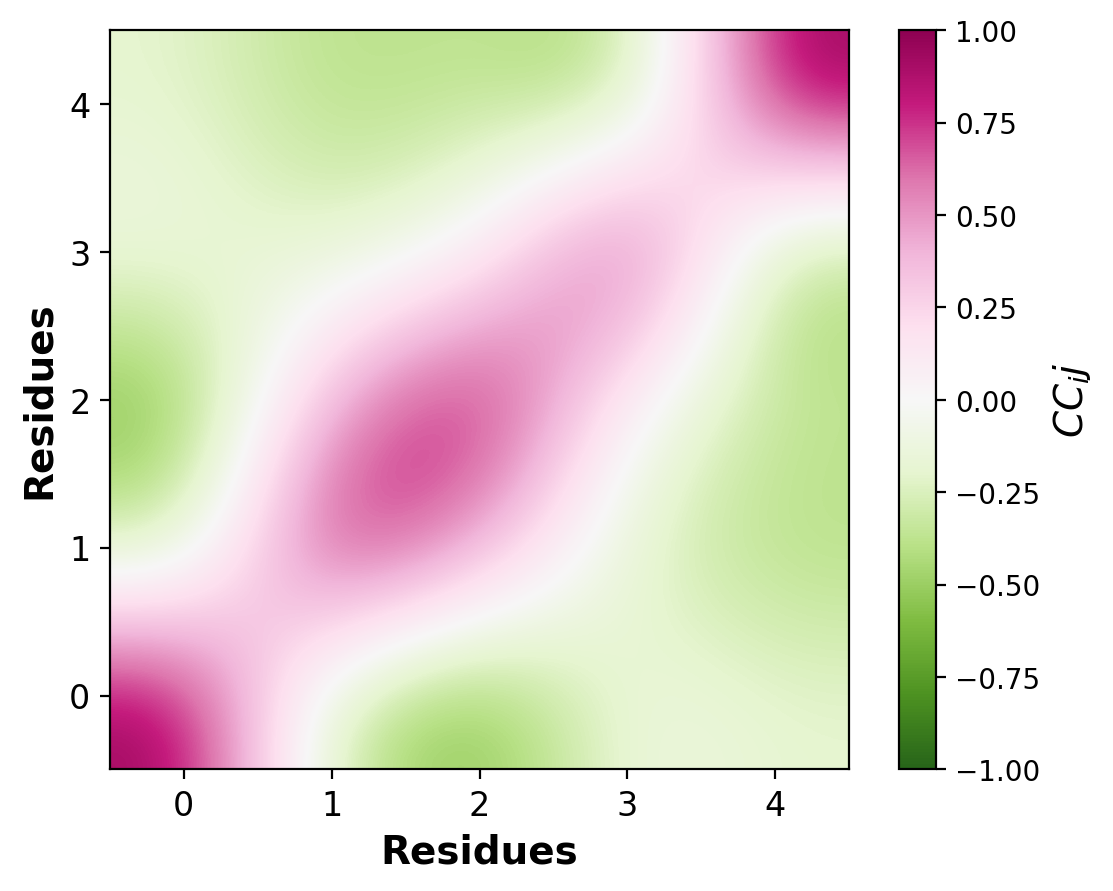

In [21]:
#@title **Pearson's Cross Correlation (CC)**

#@markdown **Provide output file names below:**
Output_name = 'cross_correlation' #@param {type:"string"}


traj_align = pt.align(traj_load, mask='@CA', ref=0)

mat_cc = matrix.correl(traj_align, '@CA')

ax = plt.imshow(mat_cc, cmap = 'PiYG_r', interpolation = 'bicubic', vmin = -1, vmax = 1, origin='lower')

plt.xlabel('Residues', fontsize = 14, fontweight = 'bold')
plt.ylabel('Residues', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
cbar1 = plt.colorbar()
cbar1.set_label('$CC_ij$', fontsize = 14, fontweight = 'bold')

plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

raw_data=pd.DataFrame(mat_cc)
raw_data.to_csv(os.path.join(workDir, Output_name + ".csv"))